# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [32]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, countDistinct, \
    min, max, avg, split, round, lit, row_number
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType, BooleanType
import datetime
from pyspark.sql.functions import year, month, dayofmonth, substring

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

### Common Functions

In [12]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

def get_user_logs(userId, sessionId=None):
    if sessionId == None:
        return data.where(data.userId == userId) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')
    else:
        return data.where((data.userId == userId) & (data.sessionId == sessionId)) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')

# Load and prepare Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [13]:
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)

In [16]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
#data = data.drop('method')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

# Define churned users using Cancellation Confirmation event (canceled)
query_churn_by_cc = data.where(data.page == 'Cancellation Confirmation')
print(f'Churned users who cancelled subscription: {query_churn_by_cc.count()}')

# Label churned (canceled) users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))

# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

# Add last level column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))

# Query churned users by downgrade event
downgraded = data.where((data.churn == 0) \
           & (data.page == 'Submit Downgrade') \
           & (data.lastLevel == 'free')) \
    .select('userId') \
    .dropDuplicates()

# Label downgraded users (churn=1)
uids = [row.userId for row in downgraded.collect()]
set_churn = udf(lambda userId, churn: 1 if userId in uids else churn, IntegerType())
data = data.withColumn('churn', set_churn('userId', 'churn'))

data.printSchema()
data.take(3)

# check count of churned users
data.where(data.churn == 1).select('userId').dropDuplicates().count()

67

### User level

#### User-Time: *Level*

In [24]:
# Add Year, Month, Day columns
data = data.withColumn('tsYear', year('tsDate')) \
    .withColumn('tsMonth', month('tsDate')) \
    .withColumn('tsDay', dayofmonth('tsDate'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', tsYear=2018, tsMonth=11, tsDay=21),
 Row(artist='Lily Allen', auth='Logged In', gender='F', itemInSession=33, length=185.25995, level='free', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', use

In [96]:
# Export user-time-level data to pandas
df = data.select('userId', col('tsMonth').alias('month'), col('tsDay').alias('day'), 'level') \
         .dropDuplicates() \
         .toPandas()

In [215]:
extracted = data \
    .groupby('userId', 'tsMonth', 'tsDay') \
    .agg(max('userRowId').alias('rowid')) \
    .select(col('userId').alias('uid'), col('tsMonth').alias('month'), col('tsDay').alias('day'), 'rowid')

In [216]:
extracted.show(5)

+------+-----+---+-----+
|   uid|month|day|rowid|
+------+-----+---+-----+
|100010|   10|  8|   40|
|100010|   10| 15|   49|
|100010|   10| 16|  104|
|100010|   10| 20|  164|
|100010|   11|  5|  236|
+------+-----+---+-----+
only showing top 5 rows



In [195]:
extracted \
    .join(data, (extracted.userId == data.userId) & (extracted.maxUserRowId == data.userRowId), how='inner') \
    .take(2)

[Row(userId='100', tsMonth=10, tsDay=26, maxUserRowId=1247, artist=None, auth='Logged In', gender='M', itemInSession=30, length=None, level='paid', method='PUT', page='Logout', registration=1537982255000, sessionId=1279, song=None, status=307, ts=1540549586000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0', userId='100', regDate=datetime.datetime(2018, 9, 26, 19, 17, 35), tsDate=datetime.datetime(2018, 10, 26, 12, 26, 26), city='Dallas-Fort Worth-Arlington', state=' TX', churn=0, userRowId=1247, userRowDescId=1968, lastLevel='paid', tsYear=2018, tsMonth=10, tsDay=26),
 Row(userId='100', tsMonth=11, tsDay=30, maxUserRowId=3214, artist=None, auth='Logged In', gender='M', itemInSession=92, length=None, level='paid', method='GET', page='Home', registration=1537982255000, sessionId=2428, song=None, status=200, ts=1543587349000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0', userId='100', regDate=datetime.datetime(

In [222]:
# Export user-time-level data to pandas
# Note: if a user has more than 1 different level per day, then we take the last level
df = extracted \
    .join(data, (extracted.uid == data.userId) & (extracted.rowid == data.userRowId), how='inner') \
    .select(data.userId, extracted.month, extracted.day, data.level) \
    .toPandas()

In [223]:
df.head()

,userId,month,day,level
0,100,10,26,paid
1,100,11,30,paid
2,100015,10,1,free
3,100018,10,15,free
4,153,11,12,paid


In [227]:
df[(df.userId == '300015') & (df.month == 10) & (df.day == 1)]

,userId,month,day,level
633,300015,10,1,paid


In [228]:
def validate_date(date_str):
    try:
        datetime.datetime.strptime(date_str, '%Y-%m-%d')
        return True
    except ValueError:
        return False
    
def create_usertime_matrix(users, start_month, end_month):
    time_interval = []
    for userId in users:
        for month in range(start_month, end_month+1):
            for day in range(1, 31+1):
                if validate_date(f'2018-{month}-{day}') == True:
                    time_interval.append({
                        'userId': userId,
                        'month': month,
                        'day': day
                    })     
    return pd.DataFrame(time_interval)

# Create user-time matrix
usertime_matrix = create_usertime_matrix(np.unique(df['userId']), 10, 12)

# Get user-time dataframe
usertime_df = usertime_matrix \
    .merge(df, how='left', \
           left_on=['userId', 'month', 'day'], \
           right_on=['userId', 'month', 'day'])

In [246]:
usertime_df[~usertime_df.level.isna()].shape

(3172, 4)

In [247]:
usertime_df.shape

(20700, 4)

In [56]:
# Add binary column (0-free, 1-paid)
df['label'] = df.apply(lambda row: 1 if row['level'] == 'paid' else 0, axis = 1)
df = df.drop('level', axis = 1)

In [75]:
# Create time matrix from 10/1/2018 to 12/31/2018
tmatrix = np.array([np.array(range(31 + 1)), np.array(range(30 + 1)), np.array(range(31 + 1))])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [82]:
time_matrix = np.array([range(31+1), range(30+1), range(31+1)])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [83]:
time_matrix

array([range(0, 32), range(0, 31), range(0, 32)], dtype=object)

In [87]:
tmatrix = np.arange(range(31+1), range(30+1), range(31+1))

TypeError: unsupported operand type(s) for -: 'range' and 'range'

In [89]:
np.array([[x for x in range(1,32)], [x for x in range(1,31)]], np.int32)

ValueError: setting an array element with a sequence.

In [94]:
np.zeros((2, 3, 4))

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [93]:
np.zeros((31, 30, 31))

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [72]:
np.unique(df['userId']).shape

(225,)

In [42]:
data.withColumn('date', substring('tsDate', 1, 10)) \
    .groupby('userId', 'date') \
    .count() \
    .show()

+------+----------+-----+
|userId|      date|count|
+------+----------+-----+
|   142|2018-10-01|  292|
|    87|2018-10-05|    3|
|   145|2018-10-07|   44|
|    44|2018-10-11|   24|
|   131|2018-10-20|   16|
|    58|2018-10-19|  251|
|    53|2018-10-22|    3|
|   100|2018-10-25|   23|
|   124|2018-10-30|  394|
|    92|2018-11-06|   89|
|    67|2018-11-07|   49|
|     4|2018-11-08|   41|
|    66|2018-11-17|   26|
|     9|2018-11-18|  114|
|   152|2018-11-19|  122|
|    71|2018-11-21|   56|
|100009|2018-10-01|   28|
|100009|2018-10-05|    4|
|100008|2018-10-16|   25|
|200017|2018-10-30|   43|
+------+----------+-----+
only showing top 20 rows



In [40]:
# Define interval with 90% of users (225)

data.withColumn('date', substring('tsDate', 1, 10)) \
    .groupby('userId', 'date') \
    .count() \
    .where(col('count') >= 225) \
    .select(min('date').alias('minDate'), max('date').alias('maxDate')) \
    .show()
    
    



+----------+----------+
|   minDate|   maxDate|
+----------+----------+
|2018-10-01|2018-11-30|
+----------+----------+



In [1347]:
# Prepare dataset
def get_df(page):
    return data.where(data.page == page) \
        .groupby('userId', 'churn', 'sessionId') \
        .agg(count('sessionId').alias('logCount')) \
        .groupby('userId', 'churn') \
        .agg(avg('logCount').alias(page)) \
        .toPandas()

In [1384]:
def get_churn_mean(page):
    return data.where(data.page == page) \
        .groupby('userId', 'churn', 'sessionId') \
        .agg(count('sessionId').alias('logCount')) \
        .groupby('userId', 'churn') \
        .agg(avg('logCount').alias(page)) \
        .groupby('churn') \
        .agg(avg(page))

In [1392]:
def get_churn_total_mean(page):
    return data.where(data.page == page) \
        .groupby('churn', 'userId') \
        .agg(count('churn').alias('logCount')) \
        .groupby('churn') \
        .agg(avg('logCount').alias(page))

In [1385]:
get_churn_mean('NextSong').show()

+-----+------------------+
|churn|     avg(NextSong)|
+-----+------------------+
|    1|63.537152578095224|
|    0| 72.96967249911357|
+-----+------------------+



In [1386]:
get_churn_mean('Thumbs Up').show()

+-----+------------------+
|churn|    avg(Thumbs Up)|
+-----+------------------+
|    1| 4.279693814443338|
|    0|4.9075917705904715|
+-----+------------------+



In [1393]:
get_churn_total_mean('NextSong').show()

+-----+------------------+
|churn|          NextSong|
+-----+------------------+
|    1| 699.8846153846154|
|    0|1108.1734104046243|
+-----+------------------+



In [1377]:
def plot_churn(page, kde=False):
    df = get_df(page)
    plt.figure(figsize=(12, 4))
    df_active = df[df.churn == 0][page]
    df_churned = df[df.churn == 1][page]
    plt.figure(figsize=(15,6));
    sb.distplot(df_active, bins=20, label='active', kde=kde);
    sb.distplot(df_churned, bins=20, label = 'churned', kde=kde);
    plt.xlabel('Average ' + page)
    ax = plt.gca()
    ax.set_title('Churn vs. Average ' + page);
    plt.legend(loc='upper right');
    plt.show()

<Figure size 864x288 with 0 Axes>

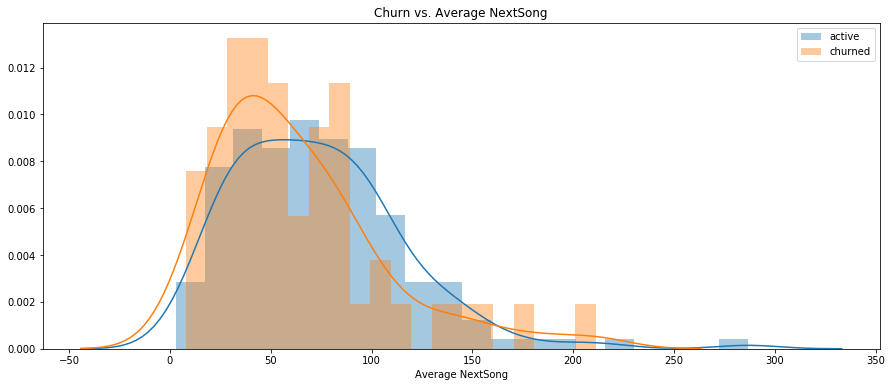

In [1402]:
plot_churn('NextSong', True)

<Figure size 864x288 with 0 Axes>

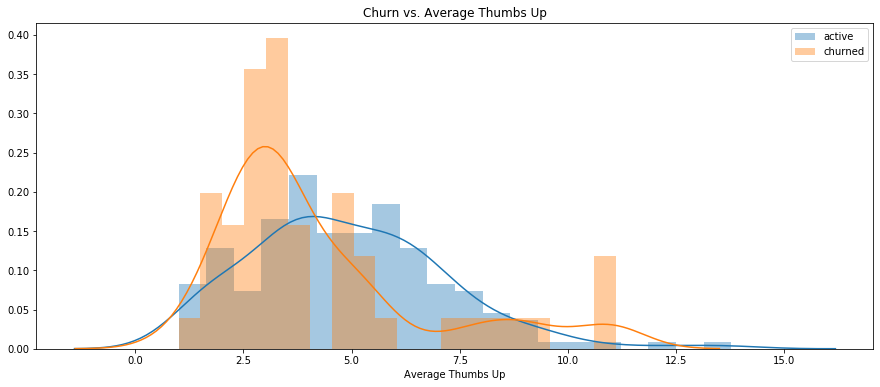

In [1361]:
plot_churn('Thumbs Up')

### Session level

In [1142]:
cols = ['sessionId', 'itemInSession', 'userId', 'tsDate', 'page']

In [1143]:
data.select(cols).sort('itemInSession').show(10)

+---------+-------------+------+-------------------+--------+
|sessionId|itemInSession|userId|             tsDate|    page|
+---------+-------------+------+-------------------+--------+
|      149|            0|300009|2018-10-17 11:20:34|NextSong|
|      183|            0|300021|2018-10-18 18:50:46|    Help|
|      173|            0|300023|2018-10-17 16:12:25|NextSong|
|      160|            0|300025|2018-10-17 07:41:52|NextSong|
|      178|            0|300021|2018-10-17 17:24:57|    Home|
|      138|            0|300001|2018-10-18 01:45:39|    Home|
|      179|            0|300009|2018-10-18 17:51:27|NextSong|
|      120|            0|300019|2018-10-18 07:24:43|    Home|
|      166|            0|300011|2018-10-16 20:07:35|    Home|
|       91|            0|300014|2018-10-18 10:46:39|    Home|
+---------+-------------+------+-------------------+--------+
only showing top 10 rows



In [1174]:
# Aggregate a given user by session extracting session's startDate, endDate, end log count
data.where(data.userId == 10) \
    .groupby('userId', 'sessionId') \
    .agg(min('tsDate').alias('startDate'), max('tsDate').alias('endDate'), count('sessionId').alias('logCount')) \
    .sort('sessionId') \
    .show()

+------+---------+-------------------+-------------------+--------+
|userId|sessionId|          startDate|            endDate|logCount|
+------+---------+-------------------+-------------------+--------+
|    10|        9|2018-10-08 04:20:20|2018-10-08 08:16:12|      70|
|    10|      595|2018-10-18 05:38:43|2018-10-19 07:26:38|     449|
|    10|     1047|2018-10-29 23:02:26|2018-10-30 00:33:51|      25|
|    10|     1414|2018-11-03 15:27:42|2018-11-03 19:43:18|      78|
|    10|     1592|2018-11-15 20:34:26|2018-11-16 01:26:29|      78|
|    10|     1981|2018-11-19 08:14:10|2018-11-19 13:49:48|      95|
+------+---------+-------------------+-------------------+--------+



In [1176]:
# Churn vs average number of logs per session
data.groupby('userId', 'sessionId') \
    .count() \
    .show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   73|
|    42|      433|   21|
|   101|      635|  855|
|   120|      627|  261|
|   140|      798|    6|
|   122|      691|    9|
|    29|     1030|   19|
|     8|     1200|   18|
|    96|     1653|  160|
|   153|     1794|   74|
|    97|     2019|   84|
|    35|     2270|   13|
|   110|     1776|   24|
|300011|       60|   36|
|   137|      136|    7|
|    40|      484|   84|
|    35|      544|   16|
|    24|      620|    8|
|    47|       46|    3|
|    85|     1098|   89|
+------+---------+-----+
only showing top 20 rows



In [1222]:
# Churn vs average number of logs per session
df = data.groupby('userId', 'sessionId') \
    .count() \
    .groupby('userId') \
    .agg(avg('count').alias('mean')) \
    .toPandas()

In [1207]:
# Log count per user-session
df = data.groupby('userId', 'sessionId') \
    .agg(count('sessionId')) \
    .show()

+------+---------+----------------+
|userId|sessionId|count(sessionId)|
+------+---------+----------------+
|    92|      358|              73|
|    42|      433|              21|
|   101|      635|             855|
|   120|      627|             261|
|   140|      798|               6|
|   122|      691|               9|
|    29|     1030|              19|
|     8|     1200|              18|
|    96|     1653|             160|
|   153|     1794|              74|
|    97|     2019|              84|
|    35|     2270|              13|
|   110|     1776|              24|
|300011|       60|              36|
|   137|      136|               7|
|    40|      484|              84|
|    35|      544|              16|
|    24|      620|               8|
|    47|       46|               3|
|    85|     1098|              89|
+------+---------+----------------+
only showing top 20 rows



In [1214]:
# Log count per user-session
data.groupby('userId', 'sessionId') \
    .agg(min('churn').alias('churn'), count('sessionId').alias('logCount')) \
    .show()

+------+---------+-----+--------+
|userId|sessionId|churn|logCount|
+------+---------+-----+--------+
|    92|      358|    0|      73|
|    42|      433|    0|      21|
|   101|      635|    1|     855|
|   120|      627|    0|     261|
|   140|      798|    0|       6|
|   122|      691|    1|       9|
|    29|     1030|    1|      19|
|     8|     1200|    0|      18|
|    96|     1653|    0|     160|
|   153|     1794|    0|      74|
|    97|     2019|    0|      84|
|    35|     2270|    0|      13|
|   110|     1776|    0|      24|
|300011|       60|    0|      36|
|   137|      136|    0|       7|
|    40|      484|    0|      84|
|    35|      544|    0|      16|
|    24|      620|    0|       8|
|    47|       46|    0|       3|
|    85|     1098|    0|      89|
+------+---------+-----+--------+
only showing top 20 rows



### Session Activity

In [1330]:
# Prepare dataset
df = data.groupby('userId', 'churn', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), ((max('ts') - min('ts'))/60000.0).alias('duration')) \
    .groupby('userId', 'churn') \
    .agg(avg('logCount').alias('avgLogsPerSession'), \
         avg('duration').alias('avgDurationPerSession')) \
    .toPandas()

#### Average logs per session 

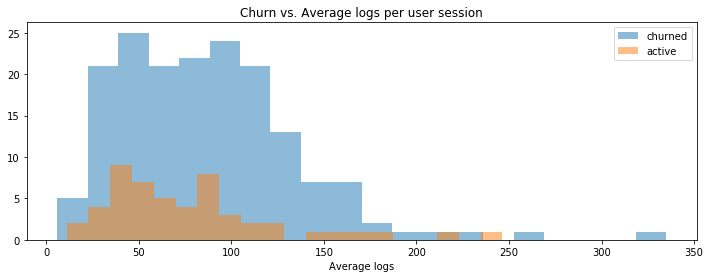

In [1333]:
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgLogsPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgLogsPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average logs')
ax = plt.gca()
ax.set_title('Churn vs. Average logs per user session');
plt.legend(loc='upper right')
plt.show()

#### Average duration per session 

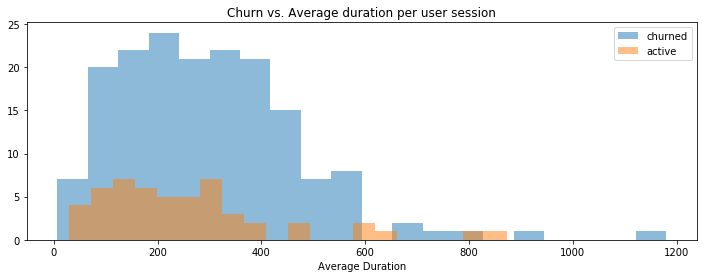

In [1335]:
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgDurationPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgDurationPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average Duration')
ax = plt.gca()
ax.set_title('Churn vs. Average duration per user session');
plt.legend(loc='upper right')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.